# Image denoising

The objective of this exercise is implementing advanced image denoising techniques

## Total variation

In the total variation approach, the denoising process consists of minimizing an energy functional using some optimization technique such as the gradient descent.

1) Given the following functions, implement functions that compute the optimization step using the l2 and total variation equations (see equations 18 and 26 in Lecture 1). Approximate the derivatives by finite differences. 

2) Show how the number of iterations and the parameter lambda affect the results in both methods.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from skimage.util import random_noise
from skimage import data

import cv2
import numpy as np

%matplotlib inline

plt.rcParams['figure.figsize'] = [16,8]


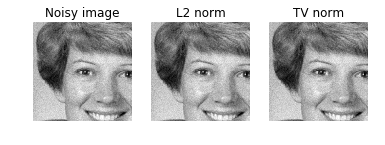

In [2]:
def l2_step(f,u,lmbda):
    #f- degraded image
    #u- input image
    
    u_xx= np.diff(u, n=2, axis=1) #(512,510)
    u_yy= np.diff(u, n=2, axis=0) #(510,512)
    
    u_xx = np.pad(u_xx, ((0, 0), (1, 1)), mode='constant', constant_values=0)
    u_yy = np.pad(u_yy, ((1, 1), (0, 0)), mode='constant', constant_values=0)
    

    grad= f - u + lmbda*(u_xx + u_yy)

    return grad


def tv_step(f,u,lmbda):
    u_x = np.diff(u, axis=1) #(512,511)
    u_y = np.diff(u, axis=0) #(511,512)
    u_xx= np.diff(u, n=2, axis=1) #(512,510)
    u_yy= np.diff(u, n=2, axis=0) #(510,512)
    u_xy= np.diff(u_x, axis=0) #(511,511)
    
    u_x = np.pad(u_x, ((0, 0), (1, 0)), mode='constant', constant_values=0) #(512,512)
    u_y = np.pad(u_y, ((1, 0), (0, 0)), mode='constant', constant_values=0) #(512,512)
    u_xx = np.pad(u_xx, ((0, 0), (1, 1)), mode='constant', constant_values=0) #(512,512)
    u_yy = np.pad(u_yy, ((1, 1), (0, 0)), mode='constant', constant_values=0) #(512,512)
    u_xy = np.pad(u_xy, ((1, 0), (1, 0)), mode='constant', constant_values=0) #(512,512)
  
    step1= lmbda*(f-u) 
    
    step2= u_xx*(u_y **2) + u_yy*(u_x **2) - 2*u_x*u_y*u_xy
    
    step3= (0.001 + u_x**2 + u_y**2)**(3/2) 
        
    grad= step1 +step2/step3
                
    return grad

def gradient_descent(f, time_steps, lmbda, delta_t, func):
    # Write your code here
    
    # Initialize u_t with the input image f
    # For each time step
    #   Compute u_t+1 from u_t using function func
    #   If there are no significative differences between u_t+1 and u_t, stop the loop
    
    print('func', func)
    i=0
    learning_rate=delta_t

    u_t=f #first initialization: noisy 
    u_t_new=0
    
    while i<time_steps and ~np.allclose(u_t, u_t_new):
            
        grad= func(f, u_t, lmbda)            
        u_t_new= u_t + learning_rate*grad


        if np.allclose(u_t_new, u_t):
            print("Converged at iteration", i+1)
            break 
        
        u_t= u_t_new
        i=i+1
  

    return u_t




im = data.astronaut()[:,:,1].astype(np.float32)/255
noisy = random_noise(im, var=0.001)

time_steps = 250 #or 1000
lmbda = 80 #or 20
delta_t = 1e-3
l2_result = gradient_descent(noisy, time_steps, lmbda, delta_t, l2_step)
tv_result = gradient_descent(noisy, time_steps, lmbda, delta_t, tv_step)


fig, ax = plt.subplots(1,3)
titles = ['Noisy image', 'L2 norm', 'TV norm']
images = [noisy, l2_result, tv_result]
for i in range(len(ax)):
    ax[i].axis('off')
    ax[i].title.set_text(titles[i])
    ax[i].imshow(images[i][50:150,150:250], cmap='gray')
plt.show()

Results obtained using lambda=80 and with max_iterations=250:

![title](Image1.png)

Results obtained using lambda=80 and with max_iterations=1000:

![title](Image2.png)


Results obtained using lambda=20 and with max_iterations=250:

![title](Image3.png)

Results obtained using lambda=20 and with max_iterations=1000:

![title](Image4.png)



Overall, we can observe that the L2 norm method smoothes the image, but loses details (edges are very blurred). This happens because in the energy functional images that have large derivatives are penalized (the ∇u is squared).

As can be seen in the images, by increasing the number of maximum iterations, the L2 norm image becomes even more blurred, which was expected since more iterations of the function were applied.
The lambda represents the importance of the smoothness term, in the lower value (lambda=20) the image is more similar to the original and not as smooth, and in the higher value (lambda=80) the image is less similar and smoother.

Usin the Total Variation method, we are able to preserve the edges more. (The ∇u is not squared, instead its absolute value is used, which penalizes the edges less).
In this method, the lambda is placed differently in the energy functional, instead representing the importance of the similarity term.
In lambda=20, the image is less similar to the noisy image and is smoother and in lambda=80, the image is more similar to the noisy image but is not as smooth, but both are much more better options than the images obtained in the L2 norm method.
Analogously to the L2 norm method, by increasing the number of maximum iterations in the TV norm, the image becomes smoother

In the L2 norm, increasing the number of iterations and increasing the lambda will lead to a smoother image. 
In the Total Variation, increasing the number of iterations and decreasing the lambda will lead to a smoother image.

In conclusion, the total variation method works much better in denoising the image.